In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7201 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [2]:
import pickle
with open('data/fixed-1000-10-0.25-5.00.pkl', 'rb') as f:
  GCH, TH = pickle.load(f)
S = 10
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(12276, int)

In [3]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [4]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [5]:
def get_Risq(p):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S : Durations
    n = tt.constant(np.clip(d,a_min=0,a_max=S+1))
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=max(tmp_u))) # V x S x S
   
    
    # The beta binomial
    R_isq =   tt.gammaln(n+1)
    R_isq -=  tt.gammaln(expanded_u+1)
    R_isq -=  tt.gammaln(n_u+1)   
    R_isq +=  tt.gammaln(expanded_u+a)
    R_isq +=  tt.gammaln(n_u+b)
    R_isq -=  tt.gammaln(n+a+b)
    R_isq +=  tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)

    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [6]:
def get_Risq0(p):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    return tt.exp(R0_sq)

In [7]:
def logp_capture(arr, phi, p, U):
    def ll_capture_f(mycaptures):
        
        # Masks: try to compute these once.
        phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
        i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
        R_isq = get_Risq(p) #
        R0_sq = get_Risq0(p) #
        
        # Likelihood of Capture Li
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        LD = arr[:, np.newaxis] * phi_v * phi
        LD_isq = tt.mul(LD, i_mask)
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2)
        
        # Likelihood of No-Capture L0
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask)
        L0 = tt.sum(LD0 * R0_sq)
        
        # Multinomial
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li))
        obj3 = U * tt.log(L0)
        
        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [8]:
#birth_init, dep = (np.array([0.4       , 0.06666667, 0.06666667, 0.06666667, 0.06666667,
#          0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667]),
# np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]))
#for UU in range(87600, 88400, 10):
#    print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, .25,  5., UU)(npdata).eval().round(4))
#print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, .25,  5., 100000-V)(npdata).eval().round(4))

In [18]:
# custom log-liklihood
# model
with pm.Model() as model2:
    # parameters
    U = pm.DiscreteUniform('Unseen', lower=V, upper=10*V)
    p = pm.Uniform('alpha', 0., 1.)
    phi    = pm.Uniform('departure', 0.1, 1., shape=S)
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, p, U), observed=npdata)

In [28]:
with model:
  #posterior = pm.sample(3, tune=0, chains=1, progressbar=False)
  step = pm.NUTS()
  #posterior = pm.sample(100000, step=step, njobs = 4)
  posterior = pm.sample(5000, cores = 1, step = step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [arrival, departure, beta, alpha]
>Metropolis: [Unseen]
100%|██████████| 5500/5500 [16:58<00:00,  5.40it/s]
There were 805 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6305 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3717962914071477, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

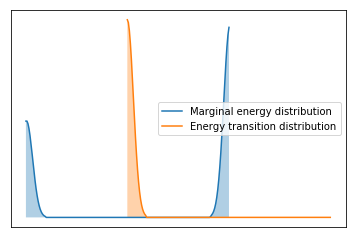

In [42]:
pm.energyplot(posterior);

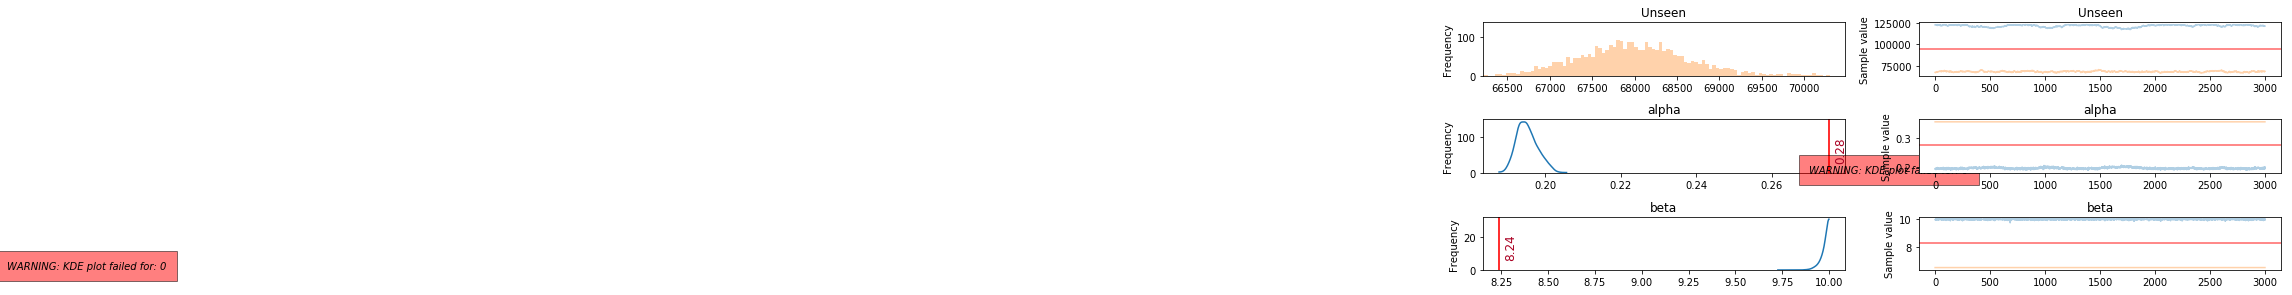

In [40]:
plot_traces(posterior[2000:], varnames=['Unseen', 'alpha', 'beta']);

In [43]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,92227.35,25236.30,2522.65,67155.00,122756.00,1.06,5.03
alpha,0.28,0.08,0.01,0.19,0.36,NaN,7.53
beta,8.24,1.74,0.17,6.50,10.00,NaN,149.87
departure__0,0.33,0.22,0.02,0.10,0.55,1.00,1201.20
departure__1,0.33,0.22,0.02,0.10,0.55,1.00,1906.89
departure__2,0.33,0.22,0.02,0.10,0.55,1.00,2239.25
departure__3,0.33,0.22,0.02,0.10,0.55,1.00,2371.27
departure__4,0.33,0.22,0.02,0.10,0.55,1.00,2359.41
departure__5,0.33,0.22,0.02,0.10,0.55,1.00,2086.73
departure__6,0.33,0.22,0.02,0.10,0.55,1.00,1870.15


In [ ]:
V

In [ ]:
model['Unseen'].logp(model.test_point)

In [ ]:
model['a'].logp(model.test_point)